In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# EDA
1. combine daily datasets into a dictionary to concat together as a whole df to manage as a whole.
<br><br>
2. extract only the necessary columns to be used in prediction
      'Province_State', 
      'Last_Update', 
      'Confirmed', 
      'Deaths', 
      'Recovered', 
      'Active', 
      'Incident_Rate',
      'Mortality_Rate',
      'People_Tested',
      'Testing_Rate',
      'Hospitalization_Rate'
      
      To reduce space and time, I will use columns which I feel are MOST important: 
      'Province_State', 'Last_Update', 'Confirmed', 'Deaths', 'Recovered', 'Active',
      'People_Tested', 'Testing_Rate', 'Mortality_Rate', 'Incident_Rate'


In [2]:
import os

csv_list = []
# append csv file names into an empty list to be iterated through afterwards
for files in sorted(os.listdir("csse_covid19_daily_us/.")):
    if files.endswith(".csv"):
        csv_list.append(files)
        
# check if it appended correctly to csv_list
print(len(csv_list))
csv_list[:5]

100


['04-12-2020.csv',
 '04-13-2020.csv',
 '04-14-2020.csv',
 '04-15-2020.csv',
 '04-16-2020.csv']

In [3]:
# iterate through csv_list and read_csv > set dates as dict keys > daily data as vals
feature_list = ['Province_State', 'Last_Update', 'Confirmed', 'Deaths', 
                'Recovered', 'Active', 'People_Tested', 'Testing_Rate', 
                'Mortality_Rate', 'Incident_Rate']
 
# datetime_idx = pd.DatetimeIndex([filename[0:-4] for filename in csv_list])
daily_states_dict = {}

for i in range(len(csv_list)):
    csv_str = 'csse_covid19_daily_us/'+csv_list[i]
    today_df = pd.read_csv(csv_str, sep=',')
    filter_df = today_df[feature_list]
    daily_states_dict[i] = filter_df

if len(daily_states_dict) == 100:
    print("Appended all 100 days and corresponding dataframes.")
else:
    print("Loop didn't work correctly.")

Appended all 100 days and corresponding dataframes.


# Data pre-processing

In [4]:
# combine dictionary items into a whole df
df = pd.concat(daily_states_dict, axis=0)

# first, reset index with dates by re-formatting date column and groupby dates
df['date'] = pd.to_datetime(df['Last_Update']).dt.strftime('%Y-%m-%d')
df.drop('Last_Update', axis=1, inplace=True)
#df.set_index('date', inplace=True) doesn't groupby them, but sets date as index
df.head()


Province_State  Confirmed  Deaths  Recovered   Active  People_Tested  \
0 0        Alabama       3563      93        NaN   3470.0        21583.0   
  1         Alaska        272       8       66.0    264.0         8038.0   
  2        Arizona       3542     115        NaN   3427.0        42109.0   
  3       Arkansas       1280      27      367.0   1253.0        19722.0   
  4     California      22795     640        NaN  22155.0       190328.0   

     Testing_Rate  Mortality_Rate  Incident_Rate        date  
0 0    460.300152        2.610160      75.988020  2020-04-12  
  1   1344.711576        2.941176      45.504049  2020-04-12  
  2    578.522286        3.246753      48.662422  2020-04-12  
  3    761.753354        2.109375      49.439423  2020-04-12  
  4    485.423868        2.812020      58.137726  2020-04-12

In [5]:
# check len(Last_Update) are all equal
valct = df.groupby('Province_State')['date'].value_counts()

valct[valct > 1]

Province_State  date      
Florida         2020-04-14    2
Name: date, dtype: int64

<p>Florida has duplicated date on the 14th of April. This will affect our analysis

In [6]:
# go back to initial, pre-processed df
df[df.Province_State == 'Florida'].head()

,,Province_State,Confirmed,Deaths,Recovered,Active,People_Tested,Testing_Rate,Mortality_Rate,Incident_Rate,date
0,10,Florida,19895,461,NaN,19434.0,182753.0,860.718651,2.317165,93.700227,2020-04-12
1,11,Florida,21019,499,NaN,122520.0,196207.0,924.083459,0.405628,579.387193,2020-04-14
2,11,Florida,21628,571,NaN,21057.0,203180.0,956.924459,2.640096,101.862202,2020-04-14
3,11,Florida,22511,596,NaN,21915.0,213509.0,1005.571337,2.647595,106.020900,2020-04-15
4,11,Florida,23343,668,NaN,22675.0,219248.0,1032.600520,2.861672,109.939402,2020-04-16


<p>It can be assumed that the update for April 13th was posted slightly past midnight (based on the exact 'ns' format from original data), which led to being considered as next day. However, the column values for the 13th, except for 'confirmed' and one or two others, seems significantly different from its previous day and the next days. 

<p>I decided that I will move the midnight data to the 13th, and alter the values for sigficantly different values to Florida's avg for that corresponding week. 

In [7]:

# 1. locate index value
df_ = df.reset_index(drop=True)
df_[(df_.Province_State=='Florida') & (df_.date == '2020-04-14')]

# 2. change date value to 13th
df_.loc[df_.index==70, 'date'] = '2020-04-13'

# 3. get first week (12-19th, excl. 13th) avg for active, mortality and incident rates
wk1_fl = df_[(df_.Province_State == 'Florida') & (df_.index != 70)].reset_index(drop=True)
wk1_fl_sub = wk1_fl.loc[:6, ['Active','Mortality_Rate','Incident_Rate']].agg(np.mean)
wk1_fl_sub

# 4. fill in the incorrect column vals with corresponding series vals
df_.loc[df_.index==70, 'Active'] = wk1_fl_sub[0]
df_.loc[df_.index==70, 'Mortality_Rate'] = wk1_fl_sub[1]
df_.loc[df_.index==70, 'Incident_Rate'] = wk1_fl_sub[2]

# check result
df_.loc[63:68]
df_[df_.Province_State == 'Florida'].head()

,Province_State,Confirmed,Deaths,Recovered,Active,People_Tested,Testing_Rate,Mortality_Rate,Incident_Rate,date
10,Florida,19895,461,NaN,19434.000000,182753.0,860.718651,2.317165,93.700227,2020-04-12
70,Florida,21019,499,NaN,22771.285714,196207.0,924.083459,2.752916,110.303397,2020-04-13
129,Florida,21628,571,NaN,21057.000000,203180.0,956.924459,2.640096,101.862202,2020-04-14
188,Florida,22511,596,NaN,21915.000000,213509.0,1005.571337,2.647595,106.020900,2020-04-15
247,Florida,23343,668,NaN,22675.000000,219248.0,1032.600520,2.861672,109.939402,2020-04-16


##### Manage missing values
* for dates, fillna(method='ffill') - depending on row placement of the state within the df
<br><br>
* other feature values: confirmed, deaths, active fill with 0
<br><br>
* if there are nulls in other rest feature vals, look over and fill with 0

In [8]:
# check count and dropna where most values are null
print(df_.info(), '\n')
print("number of NaNs: ", df_.isnull().sum().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818 entries, 0 to 5817
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province_State  5818 non-null   object 
 1   Confirmed       5818 non-null   int64  
 2   Deaths          5818 non-null   int64  
 3   Recovered       4391 non-null   float64
 4   Active          5801 non-null   float64
 5   People_Tested   5600 non-null   float64
 6   Testing_Rate    5600 non-null   float64
 7   Mortality_Rate  5700 non-null   float64
 8   Incident_Rate   5600 non-null   float64
 9   date            5799 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 454.7+ KB
None 

number of NaNs:  2235


In [9]:
# first, change to easy access names
df_.columns = df_.columns.str.lower()
df_.rename(columns={'province_state': 'state'}, inplace=True)


In [10]:
print(df_.state.unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Diamond Princess' 'District of Columbia'
 'Florida' 'Georgia' 'Grand Princess' 'Guam' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Puerto Rico' 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee'
 'Texas' 'Utah' 'Vermont' 'Virginia' 'Washington' 'West Virginia'
 'Wisconsin' 'Wyoming' 'American Samoa' 'Northern Mariana Islands'
 'Recovered' 'Virgin Islands']


In [11]:
# assess value stat and compare to entire data
print("GRAND PRINCESS: \n\n{}".format(df_[df_['state']=='Grand Princess'].agg(np.mean)), '\n\n')

print("DIAMOND PRINCESS: \n\n{}".format(df_[df_['state']=='Diamond Princess'].agg(np.mean)), '\n')


GRAND PRINCESS: 

confirmed         103.000000
deaths              2.670000
recovered           0.000000
active            100.330000
people_tested            NaN
testing_rate             NaN
mortality_rate      2.592233
incident_rate            NaN
dtype: float64 


DIAMOND PRINCESS: 

confirmed         49.0
deaths             0.0
recovered          0.0
active            49.0
people_tested      NaN
testing_rate       NaN
mortality_rate     0.0
incident_rate      NaN
dtype: float64 



In [12]:
df_.describe()

,confirmed,deaths,recovered,active,people_tested,testing_rate,mortality_rate,incident_rate
count,5818.000000,5818.000000,4391.000000,5801.000000,5.600000e+03,5600.000000,5700.000000,5600.000000
mean,32692.493469,1668.792712,11057.379868,22955.531854,3.489471e+05,5864.633381,4.047353,481.614900
std,60430.019162,4109.291674,18960.665192,49303.290427,6.208745e+05,4634.567964,2.858028,460.975763
min,0.000000,0.000000,0.000000,-120720.000000,3.000000e+00,5.391708,0.000000,0.000000
25%,2311.500000,67.000000,724.500000,842.000000,4.889600e+04,2196.716493,2.390435,139.496918
50%,10975.000000,368.500000,3157.000000,6258.000000,1.433470e+05,4735.449294,3.780917,317.451194
75%,35629.500000,1422.750000,11837.000000,20340.000000,3.897520e+05,8440.463156,5.151574,673.463513
max,407326.000000,32506.000000,177871.000000,390100.000000,6.414321e+06,26549.442542,70.370370,2093.837730


<p>Comparing feature means to the entire dataset, Diamond & Grand cruise ship 
    circumstances may not be relevant to average numbers in US, so it may be 
    feasible to extract them, as well as 'Recovered', since that is not a state.

In [13]:
# drop cruise ships & other not relevant

filterdf = df_.set_index('state')
filterdf = filterdf.drop(['Grand Princess', 'Diamond Princess', 'Recovered'], axis=0)
filterdf.reset_index(inplace=True)
filterdf.head()

,state,confirmed,deaths,recovered,active,people_tested,testing_rate,mortality_rate,incident_rate,date
0,Alabama,3563,93,NaN,3470.0,21583.0,460.300152,2.610160,75.988020,2020-04-12
1,Alaska,272,8,66.0,264.0,8038.0,1344.711576,2.941176,45.504049,2020-04-12
2,Arizona,3542,115,NaN,3427.0,42109.0,578.522286,3.246753,48.662422,2020-04-12
3,Arkansas,1280,27,367.0,1253.0,19722.0,761.753354,2.109375,49.439423,2020-04-12
4,California,22795,640,NaN,22155.0,190328.0,485.423868,2.812020,58.137726,2020-04-12


<p>Glimpsing over the difference between given 'active' and 
    'confirmed'-('deaths'+'recovered') results('active_off'), there are some states 
    that doesn't match up, indicating that residual active numbers are neither
    reported in 'deaths' or 'recovered'. 
    
<p>Although that may be something to consider, it could also be a miniscule aspect in 
    predicting y.
    
<p>Therefore, 'recovered' nulls can be filled with 0, since many of them match up with 
    the confirmed and active differences.

In [14]:
clean_df = filterdf.copy()
clean_df['recovered'] = filterdf['recovered'].fillna(0)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           5600 non-null   object 
 1   confirmed       5600 non-null   int64  
 2   deaths          5600 non-null   int64  
 3   recovered       5600 non-null   float64
 4   active          5583 non-null   float64
 5   people_tested   5600 non-null   float64
 6   testing_rate    5600 non-null   float64
 7   mortality_rate  5500 non-null   float64
 8   incident_rate   5600 non-null   float64
 9   date            5590 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 437.6+ KB


In [15]:
# check 'active' and fill with 0
clean_df[clean_df['active'].isnull()==True]['state'].unique()

array(['American Samoa'], dtype=object)

<p>Only American Samoa is missing values in active column.


In [16]:
clean_df[clean_df['state']=='American Samoa'].head()

,state,confirmed,deaths,recovered,active,people_tested,testing_rate,mortality_rate,incident_rate,date
53,American Samoa,0,0,0.0,0.0,3.0,5.391708,NaN,0.0,NaN
58,American Samoa,0,0,0.0,NaN,3.0,5.391708,NaN,0.0,NaN
114,American Samoa,0,0,0.0,NaN,3.0,5.391708,NaN,0.0,NaN
170,American Samoa,0,0,0.0,NaN,3.0,5.391708,NaN,0.0,NaN
226,American Samoa,0,0,0.0,NaN,3.0,5.391708,NaN,0.0,NaN


<p>The state has barely any reports (which is a good thing).
    Fill all of its nulls across all missing cols with 0 except for date.

In [17]:
clean_df['active'].fillna(0, inplace=True)
clean_df['mortality_rate'].fillna(0, inplace=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           5600 non-null   object 
 1   confirmed       5600 non-null   int64  
 2   deaths          5600 non-null   int64  
 3   recovered       5600 non-null   float64
 4   active          5600 non-null   float64
 5   people_tested   5600 non-null   float64
 6   testing_rate    5600 non-null   float64
 7   mortality_rate  5600 non-null   float64
 8   incident_rate   5600 non-null   float64
 9   date            5590 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 437.6+ KB


In [18]:
# check states with missing dates and fill with forward fills
print(clean_df.loc[clean_df['date'].isnull()==True, 'state'].unique())

print("missing date count: ", clean_df['date'].isnull().sum())


['American Samoa' 'Virgin Islands']
missing date count:  10


In [19]:
# check if filled in
clean_df['date'] = clean_df['date'].fillna(method='ffill')

print("missing date count: {}\n".format(clean_df['date'].isnull().sum()))
clean_df.info()

missing date count: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           5600 non-null   object 
 1   confirmed       5600 non-null   int64  
 2   deaths          5600 non-null   int64  
 3   recovered       5600 non-null   float64
 4   active          5600 non-null   float64
 5   people_tested   5600 non-null   float64
 6   testing_rate    5600 non-null   float64
 7   mortality_rate  5600 non-null   float64
 8   incident_rate   5600 non-null   float64
 9   date            5600 non-null   object 
dtypes: float64(6), int64(2), object(2)
memory usage: 437.6+ KB


In [20]:
# for some reason, 'date' is no longer datetime, so convert again
clean_df['date'] = pd.to_datetime(clean_df['date'])
clean_df.head()

,state,confirmed,deaths,recovered,active,people_tested,testing_rate,mortality_rate,incident_rate,date
0,Alabama,3563,93,0.0,3470.0,21583.0,460.300152,2.610160,75.988020,2020-04-12
1,Alaska,272,8,66.0,264.0,8038.0,1344.711576,2.941176,45.504049,2020-04-12
2,Arizona,3542,115,0.0,3427.0,42109.0,578.522286,3.246753,48.662422,2020-04-12
3,Arkansas,1280,27,367.0,1253.0,19722.0,761.753354,2.109375,49.439423,2020-04-12
4,California,22795,640,0.0,22155.0,190328.0,485.423868,2.812020,58.137726,2020-04-12


In [21]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   state           5600 non-null   object        
 1   confirmed       5600 non-null   int64         
 2   deaths          5600 non-null   int64         
 3   recovered       5600 non-null   float64       
 4   active          5600 non-null   float64       
 5   people_tested   5600 non-null   float64       
 6   testing_rate    5600 non-null   float64       
 7   mortality_rate  5600 non-null   float64       
 8   incident_rate   5600 non-null   float64       
 9   date            5600 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 437.6+ KB


# Transform feature and y values (daily value diff):

1. Get daily diff for feature and target values
    
    - aggregate each day's columns across all states. 
    - get a "safe" range and assess outliers to determine safe/risky categories
  <br><br>
2. Assess outliers (using iqr) and group into risky/normal



In [22]:
clean_df.head()

,state,confirmed,deaths,recovered,active,people_tested,testing_rate,mortality_rate,incident_rate,date
0,Alabama,3563,93,0.0,3470.0,21583.0,460.300152,2.610160,75.988020,2020-04-12
1,Alaska,272,8,66.0,264.0,8038.0,1344.711576,2.941176,45.504049,2020-04-12
2,Arizona,3542,115,0.0,3427.0,42109.0,578.522286,3.246753,48.662422,2020-04-12
3,Arkansas,1280,27,367.0,1253.0,19722.0,761.753354,2.109375,49.439423,2020-04-12
4,California,22795,640,0.0,22155.0,190328.0,485.423868,2.812020,58.137726,2020-04-12


In [23]:
dailydff = {}

for state, dfs in clean_df.groupby('state'):
    dfs_ = dfs.loc[:,['date','confirmed','deaths',
                      'recovered','active','incident_rate',
                      'people_tested','testing_rate']].set_index('date')
    for cols in dfs_.columns:
        #col_name = str(cols)
        dfs_[str(cols)+"_diff"] = round(dfs_[cols].diff(), 2)
         
    if state not in dailydff.keys():
        dailydff[state] = dfs_[[col for col in dfs_ if "_diff" in str(col)]].dropna(how='all',
                                                                                    axis=0).reset_index()
#dailydff

In [24]:
# concatenate dictionary dfs and prep to aggregate
bystate_daily = pd.concat(dailydff, axis=0)
bystate_daily.head()

date  confirmed_diff  deaths_diff  recovered_diff  \
Alabama 0 2020-04-13           171.0          6.0             0.0   
        1 2020-04-14           219.0         15.0             0.0   
        2 2020-04-15           122.0          4.0             0.0   
        3 2020-04-16           270.0         15.0             0.0   
        4 2020-04-17           226.0         15.0             0.0   

           active_diff  incident_rate_diff  people_tested_diff  \
Alabama 0        165.0                3.65              7599.0   
        1        204.0                4.67              3935.0   
        2        118.0                2.60               960.0   
        3        255.0                5.76              2314.0   
        4        211.0                4.82              1457.0   

           testing_rate_diff  
Alabama 0             162.06  
        1              83.92  
        2              20.47  
        3              49.35  
        4              31.07

In [25]:
# separate date column and unstack the states to organize as proper timeseries display
date_cols = bystate_daily['date']
states_unstack = bystate_daily.drop('date',axis=1).unstack()
states_unstack.head(5)


confirmed_diff                                            \
                           0      1      2      3      4      5      6    
Alabama                 171.0  219.0  122.0  270.0  226.0  141.0  176.0   
Alaska                    5.0    8.0    8.0    7.0    9.0    5.0    5.0   
American Samoa            0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Arizona                 163.0  104.0  155.0  273.0  274.0  213.0  209.0   
Arkansas                130.0   88.0   71.0   51.0   75.0   49.0   37.0   

                                     ... testing_rate_diff                  \
                   7      8      9   ...                89      90      91   
Alabama         191.0  238.0  276.0  ...            199.95  193.47  165.16   
Alaska            2.0    8.0    6.0  ...            197.53  286.93  152.42   
American Samoa    0.0    0.0    0.0  ...              0.00    0.00    0.00   
Arizona         135.0  188.0  217.0  ...            203.04  167.36   85.92   
Arkansas        192.0   17.0  286.0  ...            140.40  422.59   18.95   

                                                                        
                    92      93      94      95      96      97      98  
Alabama         193.45  243.92  205.17  244.86  232.09  225.12  168.36  
Alaska          394.10  904.93  947.17  326.98  403.12  635.23  352.13  
American Samoa    0.00    0.00  397.19    0.00    0.00    0.00    0.00  
Arizona         268.14  192.60  182.78  215.72   96.49  192.18  103.64  
Arkansas        242.73  181.49  171.81  216.58  182.52  204.32  452.15  

[5 rows x 693 columns]

In [26]:
# create time series dataset
datestr = sorted(set(str(datestrings)[0:10] for datestrings in date_cols.values))
state_stacked = states_unstack.stack(0)
state_ts = state_stacked.rename(columns=dict({state_stacked.columns[i]: datestr[i] for i in range(len(datestr))}))
print(len(datestr), len(state_stacked.columns))
state_ts.head(5)

99 99


2020-04-13  2020-04-14  2020-04-15  2020-04-16  \
Alabama active_diff             165.00      204.00       118.0      255.00   
        confirmed_diff          171.00      219.00       122.0      270.00   
        deaths_diff               6.00       15.00         4.0       15.00   
        incident_rate_diff        3.65        4.67         2.6        5.76   
        people_tested_diff     7599.00     3935.00       960.0     2314.00   

                            2020-04-17  2020-04-18  2020-04-19  2020-04-20  \
Alabama active_diff             211.00      136.00      172.00      185.00   
        confirmed_diff          226.00      141.00      176.00      191.00   
        deaths_diff              15.00        5.00        4.00        6.00   
        incident_rate_diff        4.82        3.01        3.75        4.07   
        people_tested_diff     1457.00     4690.00     3174.00      188.00   

                            2020-04-21  2020-04-22  ...  2020-07-12  \
Alabama active_diff             218.00      263.00  ...     1429.00   
        confirmed_diff          238.00      276.00  ...     1439.00   
        deaths_diff              20.00       13.00  ...       10.00   
        incident_rate_diff        5.08        5.89  ...       29.35   
        people_tested_diff     2626.00      234.00  ...     9804.00   

                            2020-07-13  2020-07-14  2020-07-15  2020-07-16  \
Alabama active_diff            1633.00     1955.00     1670.00    -2188.00   
        confirmed_diff         1640.00     1958.00     1710.00     1812.00   
        deaths_diff               7.00        3.00       40.00       47.00   
        incident_rate_diff       33.45       39.93       34.88       36.96   
        people_tested_diff     9486.00     8098.00     9485.00    11960.00   

                            2020-07-17  2020-07-18  2020-07-19  2020-07-20  \
Alabama active_diff            2002.00     1968.00     2122.00     1776.00   
        confirmed_diff         2021.00     2003.00     2143.00     1777.00   
        deaths_diff              19.00       35.00       21.00        1.00   
        incident_rate_diff       41.22       40.85       43.71       36.24   
        people_tested_diff    10060.00    12006.00    11380.00    11038.00   

                            2020-07-21  
Alabama active_diff            1876.00  
        confirmed_diff         1880.00  
        deaths_diff               4.00  
        incident_rate_diff       38.34  
        people_tested_diff     8255.00  

[5 rows x 99 columns]

In [27]:
bystate_reidx = bystate_daily.reset_index(level=0).rename(columns={'level_0':'state'})
#reidx = bystate_daily.reset_index(level=1,drop=True)

bystate_reidx.head()


,state,date,confirmed_diff,deaths_diff,recovered_diff,active_diff,incident_rate_diff,people_tested_diff,testing_rate_diff
0,Alabama,2020-04-13,171.0,6.0,0.0,165.0,3.65,7599.0,162.06
1,Alabama,2020-04-14,219.0,15.0,0.0,204.0,4.67,3935.0,83.92
2,Alabama,2020-04-15,122.0,4.0,0.0,118.0,2.60,960.0,20.47
3,Alabama,2020-04-16,270.0,15.0,0.0,255.0,5.76,2314.0,49.35
4,Alabama,2020-04-17,226.0,15.0,0.0,211.0,4.82,1457.0,31.07


In [28]:
# assess by date from original data to get description of distribution
bydate_diff_avg = bystate_reidx.groupby('date')#[['confirmed_diff','incident_rate_diff']].agg(np.mean)


# Assess outliers; Categorization

##### Steps:

1. Get low, high IQR bounds for each date for appropriate variables <br><br>

2. Filter out and create two new df: out-of-bounds states, normal range states <br><br>

3. using the filtered "normal" range dataset, aggregate mean for the variables (another df)<br><br>

4. with aggregated data, compute multi-linreg to select the model<br><br>

5. ts train-test split<br><br>

In [29]:
# daily distribution details and set reusable col name > check correct transform
daily_stat_confirmed, daily_stat_IR = bydate_diff_avg.confirmed_diff.describe(), bydate_diff_avg.incident_rate_diff.describe()
[
    
    
    x.rename(columns={'25%':'q1', 
                      '50%':'median', 
                      '75%':'q3'}, 
             inplace=True) for x in [daily_stat_confirmed,
                                     daily_stat_IR]
]

print("confirmed updated: \n", 
      daily_stat_confirmed.iloc[:3,1:-1])
print("\nconfirmed original describe: \n", 
      bydate_diff_avg.confirmed_diff.describe().iloc[:3,1:-1])


print("\nIR updated: \n", 
      daily_stat_IR.iloc[:3,1:-1])
print("\nIR original describe: \n",
      bydate_diff_avg.incident_rate_diff.describe().iloc[:3,1:-1])

confirmed updated: 
                   mean          std   min     q1  median      q3
date                                                            
2020-04-13  451.892857  1004.239806   0.0  20.50   100.5  423.50
2020-04-14  483.053571  1134.820089 -63.0  35.25   135.5  451.75
2020-04-15  512.142857  1561.988772   0.0  21.25   118.0  415.00

confirmed original describe: 
                   mean          std   min    25%    50%     75%
date                                                           
2020-04-13  451.892857  1004.239806   0.0  20.50  100.5  423.50
2020-04-14  483.053571  1134.820089 -63.0  35.25  135.5  451.75
2020-04-15  512.142857  1561.988772   0.0  21.25  118.0  415.00

IR updated: 
                 mean        std   min     q1  median      q3
date                                                        
2020-04-13  6.404107   8.788872 -0.00  1.315   3.255  7.2125
2020-04-14  6.930536  11.484412 -8.44  1.425   3.165  7.6625
2020-04-15  6.725357  10.629345  0.00  1.31

In [30]:
# filter: where values are < low_iqr | > high_iqr, set as risky

# 1. set "safe" low,high iqr ranges for incident_rate column (target)

q1_IR = daily_stat_IR['q1']
q3_IR = daily_stat_IR['q3']
iqr_IR = q3_IR - q1_IR
low_IR = q1_IR - 1.5 * iqr_IR
high_IR = q3_IR + 1.5 * iqr_IR
print("low, high bounds for y variable (incident rate) 7 day display: \n")
print("\nlowest: \n", low_IR[:7])
print("\nhighest : \n", high_IR[:7])

low, high bounds for y variable (incident rate) 7 day display: 


lowest: 
 date
2020-04-13    -7.53125
2020-04-14    -7.93125
2020-04-15    -9.49750
2020-04-16    -7.89625
2020-04-17   -11.42000
2020-04-18    -9.08125
2020-04-19    -8.73625
dtype: float64

highest : 
 date
2020-04-13    16.05875
2020-04-14    17.01875
2020-04-15    19.32250
2020-04-16    18.31375
2020-04-17    25.32000
2020-04-18    22.30875
2020-04-19    20.49375
dtype: float64


In [31]:
# 2. go back to ts data, and extract values based on the low, high iqr bounds

# set multi indexing
tup_list = [comb for comb in state_ts.index]
multi_idx = pd.MultiIndex.from_tuples(tup_list, names=['state', 'features'])

state_ts.set_index(multi_idx, inplace=True)
state_ts.head()


2020-04-13  2020-04-14  2020-04-15  2020-04-16  \
state   features                                                             
Alabama active_diff             165.00      204.00       118.0      255.00   
        confirmed_diff          171.00      219.00       122.0      270.00   
        deaths_diff               6.00       15.00         4.0       15.00   
        incident_rate_diff        3.65        4.67         2.6        5.76   
        people_tested_diff     7599.00     3935.00       960.0     2314.00   

                            2020-04-17  2020-04-18  2020-04-19  2020-04-20  \
state   features                                                             
Alabama active_diff             211.00      136.00      172.00      185.00   
        confirmed_diff          226.00      141.00      176.00      191.00   
        deaths_diff              15.00        5.00        4.00        6.00   
        incident_rate_diff        4.82        3.01        3.75        4.07   
        people_tested_diff     1457.00     4690.00     3174.00      188.00   

                            2020-04-21  2020-04-22  ...  2020-07-12  \
state   features                                    ...               
Alabama active_diff             218.00      263.00  ...     1429.00   
        confirmed_diff          238.00      276.00  ...     1439.00   
        deaths_diff              20.00       13.00  ...       10.00   
        incident_rate_diff        5.08        5.89  ...       29.35   
        people_tested_diff     2626.00      234.00  ...     9804.00   

                            2020-07-13  2020-07-14  2020-07-15  2020-07-16  \
state   features                                                             
Alabama active_diff            1633.00     1955.00     1670.00    -2188.00   
        confirmed_diff         1640.00     1958.00     1710.00     1812.00   
        deaths_diff               7.00        3.00       40.00       47.00   
        incident_rate_diff       33.45       39.93       34.88       36.96   
        people_tested_diff     9486.00     8098.00     9485.00    11960.00   

                            2020-07-17  2020-07-18  2020-07-19  2020-07-20  \
state   features                                                             
Alabama active_diff            2002.00     1968.00     2122.00     1776.00   
        confirmed_diff         2021.00     2003.00     2143.00     1777.00   
        deaths_diff              19.00       35.00       21.00        1.00   
        incident_rate_diff       41.22       40.85       43.71       36.24   
        people_tested_diff    10060.00    12006.00    11380.00    11038.00   

                            2020-07-21  
state   features                        
Alabama active_diff            1876.00  
        confirmed_diff         1880.00  
        deaths_diff               4.00  
        incident_rate_diff       38.34  
        people_tested_diff     8255.00  

[5 rows x 99 columns]

In [ ]:
#ignore here:
#state_ts.query("features == 'confirmed_diff' and state not in @outbound['2020-04-13']")['2020-04-13'].agg(np.mean)
#outbound['2020-04-13']

In [32]:
#state_ts.loc['Alabama','incident_rate_diff'] #['2020-04-13']

uniq_states = set(midx[0] for midx in state_ts.index)
outbound = {}
for i, date in enumerate(state_ts.columns):
    daily_risk_states = []
    for statename in uniq_states:
        if (state_ts.loc[statename, 'incident_rate_diff'][date] < low_IR.loc[date] or
        state_ts.loc[statename, 'incident_rate_diff'][date] > high_IR.loc[date]):
            #print("date: {}, state: {}".format(date, statename))
            daily_risk_states.append(statename)
    if date not in outbound.keys():
        outbound[date] = daily_risk_states
        

In [33]:
# use groupby dates to aggregate the avg across all states filtered

# base aggregated mean df to compare with filtered dfs
bystate_agg_mean = bystate_reidx.groupby('date')[[
    'confirmed_diff', 'deaths_diff', 'recovered_diff', 'active_diff', 
        'people_tested_diff', 'testing_rate_diff', 'incident_rate_diff'
]].agg(np.mean)

good_mean = bystate_agg_mean.copy()
bad_mean = bystate_agg_mean.copy()
# aggregated by median as well, just to compare how deviant mean is in filtered
good_median = bystate_agg_mean.copy()
bad_median = bystate_agg_mean.copy()

for date, each_df in bystate_reidx.groupby('date'):
    strdate = str(date)[:10]
    good_mean.loc[strdate] = each_df.query(f'state not in @outbound["{strdate}"]')[[
        'confirmed_diff', 'deaths_diff', 'recovered_diff', 'active_diff', 
        'people_tested_diff', 'testing_rate_diff', 'incident_rate_diff'
    ]].agg(np.mean)
    
    bad_mean.loc[strdate] = each_df.query(f'state in @outbound["{strdate}"]')[[
        'confirmed_diff', 'deaths_diff', 'recovered_diff', 'active_diff', 
        'people_tested_diff', 'testing_rate_diff', 'incident_rate_diff'
    ]].agg(np.mean)
    
    good_median.loc[strdate] = each_df.query(f'state not in @outbound["{strdate}"]')[[
        'confirmed_diff', 'deaths_diff', 'recovered_diff', 'active_diff', 
        'people_tested_diff', 'testing_rate_diff', 'incident_rate_diff'
    ]].agg(np.median)
    
    bad_median.loc[strdate] = each_df.query(f'state in @outbound["{strdate}"]')[[
        'confirmed_diff', 'deaths_diff', 'recovered_diff', 'active_diff', 
        'people_tested_diff', 'testing_rate_diff', 'incident_rate_diff'
    ]].agg(np.median)



In [34]:
good_mean.head()

,confirmed_diff,deaths_diff,recovered_diff,active_diff,people_tested_diff,testing_rate_diff,incident_rate_diff
date,,,,,,,
2020-04-13,213.571429,9.102041,25.857143,204.469388,1716.448980,51.319184,3.615918
2020-04-14,227.208333,17.312500,44.458333,209.895833,2004.395833,40.209167,3.750417
2020-04-15,244.020000,18.040000,33.600000,225.980000,2393.500000,48.618200,3.855600
2020-04-16,284.918367,18.244898,51.979592,266.673469,2259.612245,34.627347,4.240000
2020-04-17,356.160000,19.940000,40.960000,336.220000,2433.540000,47.271400,5.511000


In [35]:
# compare to daily stat distribution for incident_rate
daily_stat_IR.head()

,count,mean,std,min,q1,median,q3,max
date,,,,,,,,
2020-04-13,56.0,6.404107,8.788872,-0.00,1.3150,3.255,7.2125,39.83
2020-04-14,56.0,6.930536,11.484412,-8.44,1.4250,3.165,7.6625,55.32
2020-04-15,56.0,6.725357,10.629345,0.00,1.3100,3.300,8.5150,67.81
2020-04-16,56.0,7.907143,11.217367,0.00,1.9325,4.585,8.4850,54.78
2020-04-17,56.0,8.871607,11.541513,-1.71,2.3575,4.770,11.5425,61.17


In [36]:
# same thing with bad/risky filtered mean
bad_mean.head()

,confirmed_diff,deaths_diff,recovered_diff,active_diff,people_tested_diff,testing_rate_diff,incident_rate_diff
date,,,,,,,
2020-04-13,2120.142857,151.857143,3.428571,2289.898571,6429.714286,65.558571,25.921429
2020-04-14,2018.125000,184.000000,8.625000,1552.713750,6300.375000,85.838750,26.011250
2020-04-15,2746.500000,265.333333,13.333333,2481.166667,6910.000000,80.841667,30.640000
2020-04-16,2498.571429,528.142857,11.428571,1970.428571,6798.285714,118.811429,33.577143
2020-04-17,2349.500000,476.666667,2.333333,1872.833333,3104.500000,83.268333,36.876667


<p>
    Just comparing the incident_rate_diff columns across original distribution table,
    filtered "normal" and "risky" states, based on incident rate(ir) daily change, 
    it is certain that the mean of ir was significanlty affected by the
    outliers' higher ir ranges. We can see this difference in the good_mean df, where
    the average daily ir diff is very similar to the median prior to filtering. Also,
    the avg daily ir diff is not only far from median, but also from mean prior to
    filtering. 
    
<p>
    Although few feature variables cannot be deciphered in significance in 
    predicting the y (since the values may be correlated with
    the population size of each state rather than risk rate), we can most defintely
    emphasize the fact that recovery daily changes are significantly higher
    in good_mean or "normal" state df than those that are out of safe bounds.
    
<p>
    Using these filtered datasets, the target value prediction can be done with less
    faultiness.

In [37]:
# just for self-reference, looking over the median aggregates 
good_median.head()

,confirmed_diff,deaths_diff,recovered_diff,active_diff,people_tested_diff,testing_rate_diff,incident_rate_diff
date,,,,,,,
2020-04-13,71.0,2.0,0.0,71.0,876.0,31.330,2.600
2020-04-14,103.5,7.5,0.0,91.5,781.5,25.715,2.670
2020-04-15,92.0,5.0,0.0,88.5,986.0,30.510,2.670
2020-04-16,115.0,7.0,0.0,112.0,953.0,30.750,3.750
2020-04-17,137.0,5.0,0.0,132.0,1304.0,36.255,3.965


In [38]:
bad_median.head()

,confirmed_diff,deaths_diff,recovered_diff,active_diff,people_tested_diff,testing_rate_diff,incident_rate_diff
date,,,,,,,
2020-04-13,1391.0,88.0,0.0,1304.0,3207.0,63.360,20.280
2020-04-14,953.0,70.5,0.0,884.5,4042.0,57.645,18.075
2020-04-15,1260.0,230.5,0.0,1029.5,4274.5,78.115,24.650
2020-04-16,1129.0,9.0,0.0,1026.0,2979.0,93.900,31.670
2020-04-17,1573.0,101.0,0.0,1472.0,2518.5,64.445,33.910


In [39]:
daily_stat_confirmed.head()

,count,mean,std,min,q1,median,q3,max
date,,,,,,,,
2020-04-13,56.0,451.892857,1004.239806,0.0,20.50,100.5,423.50,6716.0
2020-04-14,56.0,483.053571,1134.820089,-63.0,35.25,135.5,451.75,7271.0
2020-04-15,56.0,512.142857,1561.988772,0.0,21.25,118.0,415.00,11434.0
2020-04-16,56.0,561.625000,1366.212529,0.0,26.00,149.5,581.25,9237.0
2020-04-17,56.0,569.732143,1078.936286,-112.0,43.00,173.5,621.00,6906.0


<p>
    Can't help to note that median daily confirmed difference prior to filtering is
    highly resonate with good_median daily confirmed diff values.

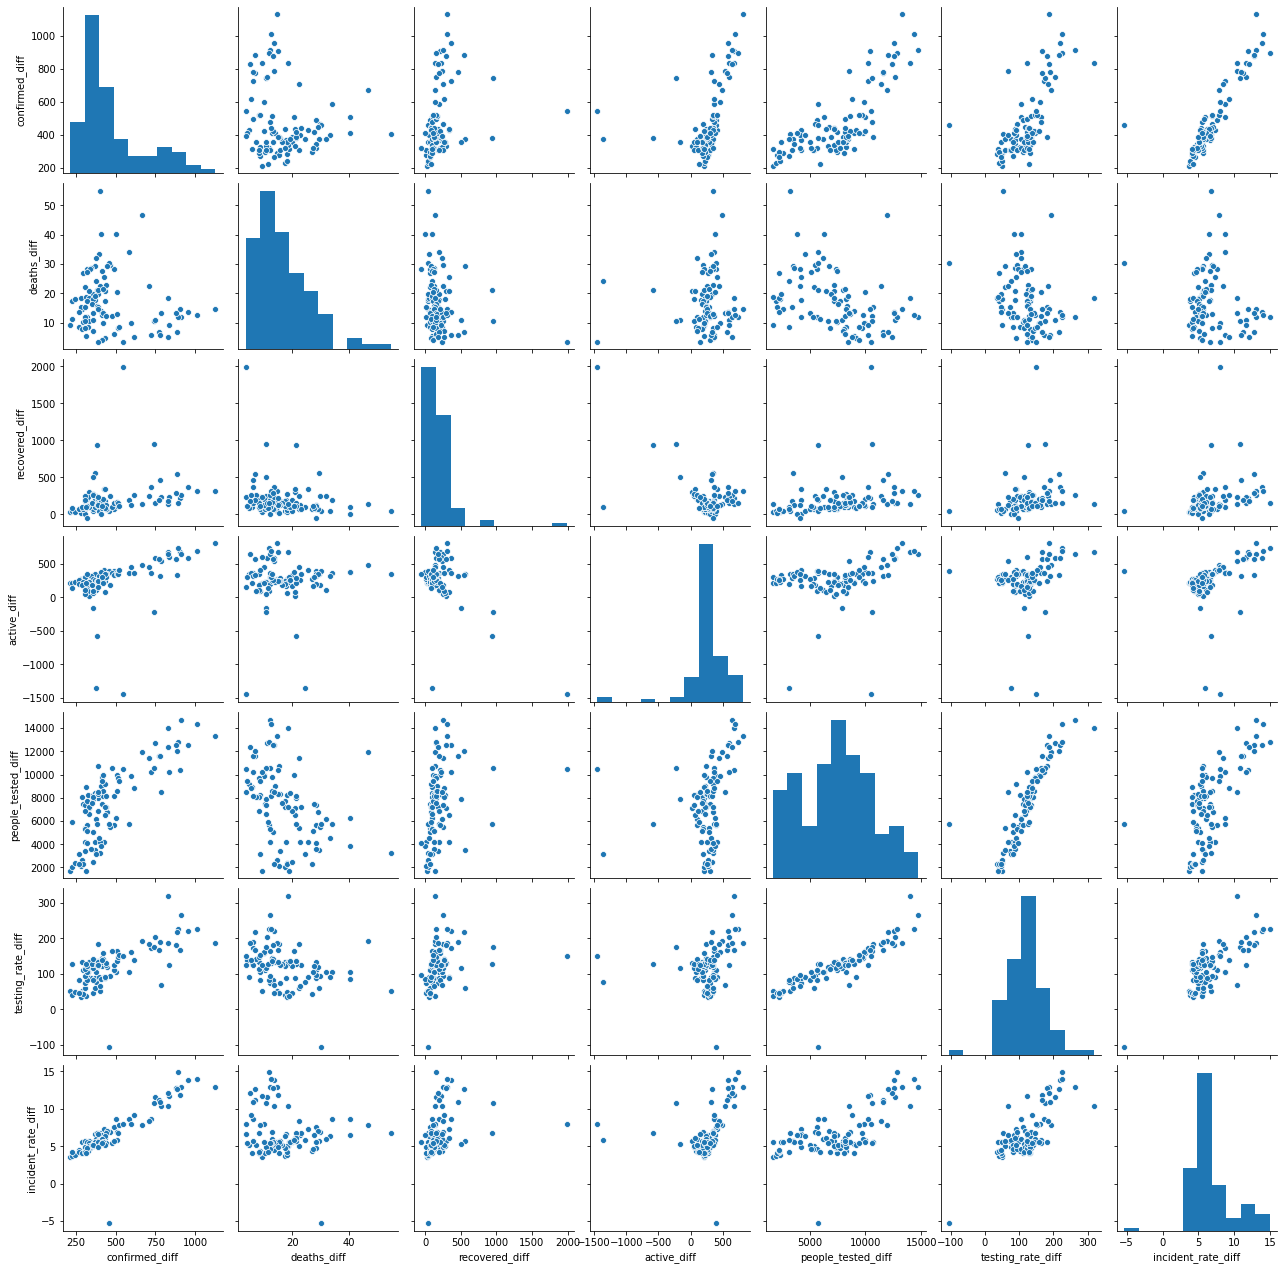

In [40]:
# plots
sns.pairplot(good_mean)


In [41]:
good_mean.corr()

,confirmed_diff,deaths_diff,recovered_diff,active_diff,people_tested_diff,testing_rate_diff,incident_rate_diff
confirmed_diff,1.000000,-0.156553,0.279917,0.432695,0.785131,0.679863,0.879438
deaths_diff,-0.156553,1.000000,-0.224458,0.045675,-0.379907,-0.301051,-0.154214
recovered_diff,0.279917,-0.224458,1.000000,-0.546409,0.291605,0.254241,0.295798
active_diff,0.432695,0.045675,-0.546409,1.000000,0.294018,0.237395,0.346565
people_tested_diff,0.785131,-0.379907,0.291605,0.294018,1.000000,0.868493,0.657612
testing_rate_diff,0.679863,-0.301051,0.254241,0.237395,0.868493,1.000000,0.736166
incident_rate_diff,0.879438,-0.154214,0.295798,0.346565,0.657612,0.736166,1.000000


<p>
    The correlations of most feature variables with target(incident rate) is definitely different from the correlation table I saw in the very beginning with the original df.
<p>
    Using daily diff mean aggregates and extracting outliers, now the only feature variables correlated most highly to ir diff are confirmed diff and testing rate diff (and somewhat people tested diff, but I think it can go hand in hand with testing rate).

<p>
    The relationship between confirmed diff and ir diff stands out the most. The pairplot shows a clean linearity, with corr value of .88

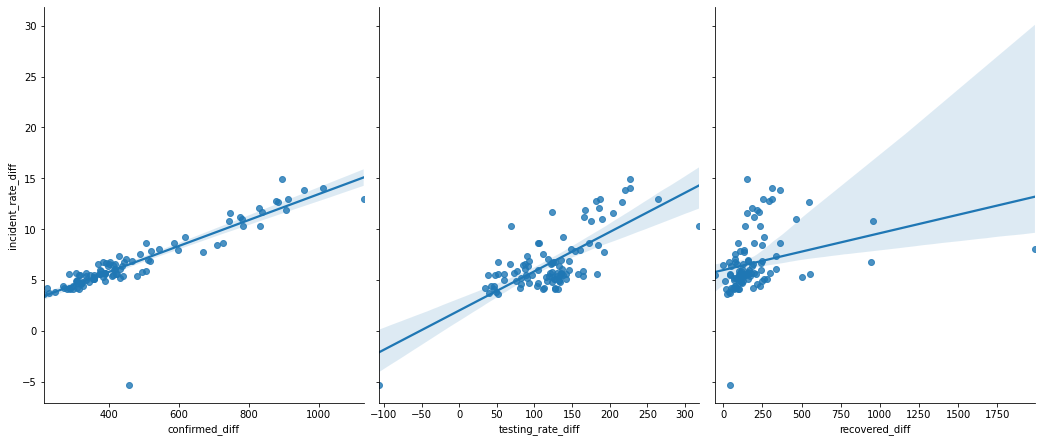

In [42]:
# use the three prominent variables plus recovered diff(just to see) for regression line
sns.pairplot(good_mean, x_vars=['confirmed_diff',
                                'testing_rate_diff',
                                'recovered_diff'], 
             y_vars='incident_rate_diff', 
             height=6, 
             aspect=0.8, 
             kind='reg')


<p>Although recovered diff mean values seemed significantly segregated between bad and good datasets, the regression line implies high variability in 'recovered' daily diff. The rest two seems to fit what we hoped to see. 
    
<p>The only thing unfavorable about the correlation with testing rate diff and ir diff is that testing rate feature must be indicating that the higher the rate, the higher the incident rate as well, yet most are clustered around 50 to 200 daily changes. Its ambiguity should be considered throughout the analysis and prediction.

In [43]:
# use simple linreg: confirmed diff & incident rate diff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics


feature_col = ['confirmed_diff']
X = good_mean[feature_col]
y = good_mean.incident_rate_diff

# instantiate and fit
ir_linreg = LinearRegression()
ir_linreg.fit(X, y)

# print the coefficients-
print("The y intercept:", ir_linreg.intercept_)
print("The single coefficient:", ir_linreg.coef_)

The y intercept: 0.7006604003706576
The single coefficient: [0.01275164]


(0.0, 16.95469635306007)

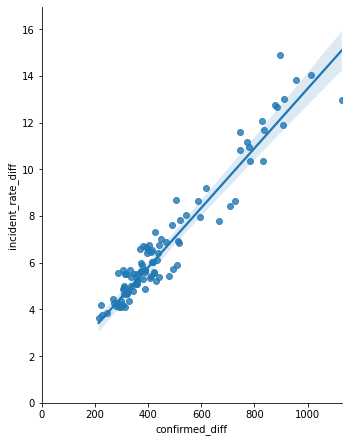

In [44]:
# pairplot of above 
sns.pairplot(good_mean,x_vars=['confirmed_diff'],y_vars='incident_rate_diff',height=6, aspect=0.8,kind='reg')
sns.mpl.pyplot.xlim(0,)
sns.mpl.pyplot.ylim(0,)

$$y = \beta_0 + \beta_1x$$
$$y = 0.7006 + 0.0127 \times 71$$

In [73]:
print("y =", 0.7006+0.0127*213)

y = 3.4057


In [72]:
ir_linreg.predict([[213]])

array([3.41676031])

> *with 213 confirmed count increase, there is ~3.41 increase in incident rate*
<p> Manual calculation of y using intercept, coef and feature value, and using the model prediction method yields incident rate somewhat close to our expected avg incident rate diff (expected: 3.61).


R^2: 0.7734105013099851


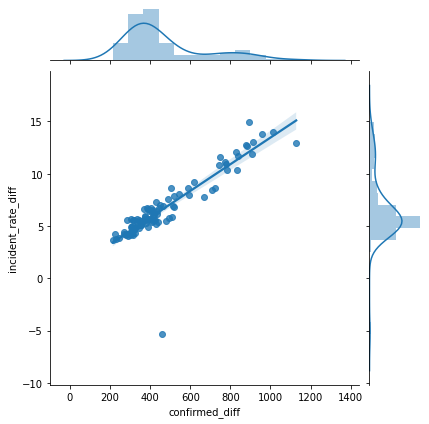

In [75]:
# get r squared
sns.jointplot('confirmed_diff', 'incident_rate_diff', good_mean, kind="reg")
print("R^2:", stats.pearsonr(X.values.flatten(),y.values)[0]**2)

In [87]:
# sklearn's r^2 evaluation
simple_y_pred = ir_linreg.predict(X)
simple_r2 = metrics.r2_score(y, simple_y_pred)
simple_r2

0.7734105013099852

<p> R-squared value resulted pretty high, which means that our simple linear regression model emulates the variability within our good_mean data at a score of 77.3%. In other words, 77.3% of our data points fit the regression model.

In [128]:
# evaluate multiple linreg this time
# create X and y except now with more columns in X
x_feats = ['confirmed_diff', 'testing_rate_diff', 'recovered_diff']
X_mult = good_mean[x_feats]
y_mult = good_mean.incident_rate_diff

#fit
multi_linreg = LinearRegression()
multi_linreg.fit(X_mult, y_mult)

# get intercept and coef
coef = [round(mlc, 4) for mlc in multi_linreg.coef_]
intercept =  multi_linreg.intercept_

# print values 
print("intercept: ", round(intercept, 4))
print("coef: {}\n".format(coef))

list(zip(x_feats, coef))

intercept:  0.2427
coef: [0.0101, 0.0133, 0.0004]



[('confirmed_diff', 0.0101),
 ('testing_rate_diff', 0.0133),
 ('recovered_diff', 0.0004)]

In [133]:
# predict & r^2 score
y_mult_pred = multi_linreg.predict(X_mult)
multi_r2 = metrics.r2_score(y_mult, y_mult_pred)

if multi_r2 > simple_r2:
    print("R^2 for multiple features (confirmed, testing rate, recovered diff): {}\n\n is greater than our simple linreg."
         .format(round(multi_r2, 4)))
else:
    print("simple linreg model yielded greater r^2 score.")

    

R^2 for multiple features (confirmed, testing rate, recovered diff):  0.8102

 is greater than our simple linreg.


In [127]:
# just for the sake of it, try using all features against y
x_allfeats = ['confirmed_diff', 'deaths_diff', 'recovered_diff',
              'active_diff', 'testing_rate_diff', 'people_tested_diff']
X_allfeats = good_mean[x_allfeats]
y_allfeats = good_mean.incident_rate_diff

#fit
allfeat_linreg = LinearRegression()
allfeat_linreg.fit(X_allfeats, y_allfeats)

# get intercept and coef
coeffs = [round(c, 4) for c in allfeat_linreg.coef_]
intercepts =  allfeat_linreg.intercept_

# print values 
print("intercept: ", round(intercept, 4))
print("coef: {}\n".format(coeffs))

[print(tups,'\f') for tups in list(zip(x_allfeats, coeffs))]


y_allfeat_pred = allfeat_linreg.predict(X_allfeats)
allfeat_r2 = metrics.r2_score(y_allfeats, y_allfeat_pred)

print("\nR^2 score: ", round(allfeat_r2, 4))

intercept:  0.2427
coef: [0.0137, -0.0197, 0.001, 0.0004, 0.0362, -0.0007]

('confirmed_diff', 0.0137) 
('deaths_diff', -0.0197) 
('recovered_diff', 0.001) 
('active_diff', 0.0004) 
('testing_rate_diff', 0.0362) 
('people_tested_diff', -0.0007) 

R^2 score:  0.8968


<p> multiple linreg using all feature columns yields even greater R^2 score.

In [140]:

alldiff_agg = bystate_reidx.groupby(['date'])[['confirmed_diff', 'deaths_diff', 
                                               'recovered_diff', 'active_diff', 
                                               'testing_rate_diff', 'people_tested_diff',
                                               'incident_rate_diff']].agg(np.mean)

In [141]:
# Now, try the linreg prediction using original diff dataset
x_allfeats = ['confirmed_diff', 'deaths_diff', 'recovered_diff',
              'active_diff', 'testing_rate_diff', 'people_tested_diff']
X_nofilter = alldiff_agg[x_allfeats]
y_nofilter = alldiff_agg.incident_rate_diff

#fit
nofilter_linreg = LinearRegression()
nofilter_linreg.fit(X_nofilter, y_nofilter)

# get intercept and coef
nofilter_coef = [round(c, 4) for c in nofilter_linreg.coef_]
nf_intercepts =  nofilter_linreg.intercept_

# print values 
print("intercept: ", round(nf_intercepts, 4))
print("coef: {}\n".format(nofilter_coef))

[print(tups,'\f') for tups in list(zip(X_nofilter, nofilter_coef))]


y_nofilter_pred = nofilter_linreg.predict(X_nofilter)
nofiltered_r2 = metrics.r2_score(y_nofilter, y_nofilter_pred)

print("\nR^2 score: ", round(nofiltered_r2, 4))

intercept:  1.8852
coef: [0.0132, -0.0222, 0.0004, 0.0001, 0.0635, -0.0012]

('confirmed_diff', 0.0132) 
('deaths_diff', -0.0222) 
('recovered_diff', 0.0004) 
('active_diff', 0.0001) 
('testing_rate_diff', 0.0635) 
('people_tested_diff', -0.0012) 

R^2 score:  0.8739


##### Measure and evaluate via mean errors

In [190]:
print("not filtered dataset y_pred: \n", y_nofilter_pred[:17])
print('\n"normal" dataset y_pred: \n', y_allfeat_pred[:17])

not filtered dataset y_pred: 
 [ 7.9868601   7.31467331  7.66256707  7.10993758  8.26097945  8.85498628
  7.24674205  7.93098041  7.54382805  5.3714819   7.17106709 10.26024826
  9.27867337  7.93466109  6.80064869  7.09853445  8.46468286]

"normal" dataset y_pred: 
 [4.5128188  3.96083057 4.21245295 4.38540311 5.68075799 5.36302507
 4.80480776 4.86726184 4.64298094 3.39994512 5.27733939 7.21591182
 5.45853021 4.9105369  4.6511189  5.92482411 6.1826184 ]


<p> Although the R-squared score is as fairly high as the one for multi-linreg (all features) from the "good" dataset, the predictions are greatly impacted by the outliers. Therefore, it is best to continue using segregated datasets.

In [198]:
"""print("Not filtered observed incident rate change: \n") 
for i in range(0,17,8):
    print(', '.join([str(round(vals, 4)) 
                     for vals in alldiff_agg['incident_rate_diff'][i:i+8]
                     .values]), end='/\n')
"""
print("\nGood filtered observed incident rate change: \n") 
for i in range(0,17,8):
    print(', '.join([str(round(vals, 4)) 
                     for vals in good_mean['incident_rate_diff'][i:i+8]
                     .values]), end='/\n')

print('\n"normal" dataset y_pred: \n', y_allfeat_pred[:17])


Good filtered observed incident rate change: 

3.6159, 3.7504, 3.8556, 4.24, 5.511, 5.534, 5.5604, 4.1312/
4.3661, 4.9992, 6.7498, 7.3257, 5.6874, 4.8938, 4.4582, 5.6385/
5.53, 5.8996, 8.6413, 6.6041, 4.256, 6.5573, 6.41, 6.4791/

"normal" dataset y_pred: 
 [4.5128188  3.96083057 4.21245295 4.38540311 5.68075799 5.36302507
 4.80480776 4.86726184 4.64298094 3.39994512 5.27733939 7.21591182
 5.45853021 4.9105369  4.6511189  5.92482411 6.1826184 ]


In [208]:
# define observed y values
goody_true = good_mean.loc[:,'incident_rate_diff'].values
#print(type(y_true), type(y_allfeat_pred), sep=', ')

# get MAE using y_pred from multi-linreg (all features)
good_multi_mae = metrics.mean_absolute_error(goody_true, y_allfeat_pred)
print("MAE for good multi-linreg data: {:.4f}"
      .format(good_multi_mae))

# do the same for single linear regression model (confirmed_diff)
simp_ypred = ir_linreg.predict(X)
good_simp_mae = metrics.mean_absolute_error(goody_true, simp_ypred)
print("MAE for good simple-linreg data: {:.4f}\n"
      .format(good_simp_mae))

#--------------------------
# Now get MSE
good_multi_mse = metrics.mean_squared_error(goody_true, y_allfeat_pred)
print("MSE for good multi-linreg data: {:.4f}"
      .format(good_multi_mse))

good_simp_mse = metrics.mean_squared_error(goody_true, simp_ypred)
print("MSE for good simple linreg data: {:.4f}\n"
      .format(good_simp_mse))
#---------------------------
# RMSE
good_multi_rmse = np.sqrt(good_multi_mse)
print("RMSE for good multi-linreg data: {:.4f}"
      .format(good_multi_rmse))

good_simp_rmse = np.sqrt(good_simp_mse)
print("RMSE for good simple linreg data: {:.4f}"
      .format(good_simp_rmse))


MAE for good multi-linreg data: 0.6160
MAE for good simple-linreg data: 0.6757

MSE for good multi-linreg data: 0.8919
MSE for good simple linreg data: 1.9575

RMSE for good multi-linreg data: 0.9444
RMSE for good simple linreg data: 1.3991


<p> The error measurements are quite satisfactory, especially with all features incorporated.

In [280]:
# got trailed off here due to error during model fitting process with bad dataset
#bad_mean.isnull().sum() shows 6 NaN rows for all columns. Check why:
bad_nulls_idx = []
for cols in bad_mean:
    bad_nulls_idx.extend(bad_mean[bad_mean[cols].isnull()==True].index)

null_idx_set = set(bad_nulls_idx)
null_idx_list = [str(d)[:10] for d in list(null_idx_set)]

#bad_mean.loc['2020-05-13':'2020-05-18']
# check my assumption that there were no "bad" values for those specific dates
for keys in null_idx_list:
    if outbound[keys] == []:
        print("{}: empty dataset!".format(keys))
    else:
        print("{}: not empty..".format(keys))

2020-06-01: empty dataset!
2020-06-10: empty dataset!
2020-05-24: empty dataset!
2020-05-16: empty dataset!
2020-06-07: empty dataset!
2020-06-16: empty dataset!


<p> 2 different approaches I plan to take in terms of subsequent analyses of data for the best forecast ml production:
    
1. set aside the null rows in bad_mean dataset and include it in the testing session. Continue with daily value change datasets and ml process.
    
2. create new df of 7-day rolling means and continue with the ml process (would need to repeat model fitting & evaluations
    

In [463]:
# assessing 7-day aggregation methods and result validity

# rolling & correlation to observed values in incident_rate_diff 
pd.merge(bad_mean.incident_rate_diff,
         bad_mean.rolling(7)
         .mean()['incident_rate_diff'],
         how='outer',
         left_index=True,
         right_index=True
        ).corr()

# define weekly ewm mean and resampled mean 
bad_ewm = bad_mean.ewm(span=7).mean()['incident_rate_diff']
bad_resamp = bad_mean.resample(rule = 'W').mean()['incident_rate_diff']

# correlations for each methods against the original
pd.merge(bad_mean.incident_rate_diff,
         bad_ewm,
         how='outer',
         left_index=True,
         right_index=True
        ).corr()

pd.merge(bad_mean.incident_rate_diff,
         bad_resamp,
         how='outer',
         left_index=True,
         right_index=True
        ).corr()

# fill in using 2 day resampling (experimenting)
bad_resamp_2D = bad_mean.resample(rule = '2D').mean()['incident_rate_diff']
# resampled mean of incident_rate_diff over 2 days starting from index 1
bad_resamp_2D_sub = bad_mean[1:].resample(rule = '2D').mean()['incident_rate_diff']
# merge the 2 day resampled "bad" IR means to fill in dates
bad_2Dresampled = pd.merge(bad_resamp_2D,
                           bad_resamp_2D_sub,
                           how='outer',
                           on='incident_rate_diff',
                           left_index=True,
                           right_index=True)

# see correlation between original values and filled in     
bad_resamp_merged = pd.merge(bad_mean.incident_rate_diff,
                     bad_2Dresampled,
                     how='outer',
                     left_index=True,
                     right_index=True,
                            suffixes=('_base', '_2d'))
print("Correlations with 2 day resampled fills: \n",
            pd.merge(bad_mean.incident_rate_diff,
                     bad_2Dresampled,
                     how='outer',
                     left_index=True,
                     right_index=True).corr()
     )
print()
print(bad_resamp_merged.head(), bad_resamp_merged.tail(), sep='\n')

Correlations with 2 day resampled fills: 
                       incident_rate_diff_x  incident_rate_diff_y
incident_rate_diff_x              1.000000              0.910958
incident_rate_diff_y              0.910958              1.000000

            incident_rate_diff_base  incident_rate_diff_2d
date                                                      
2020-04-13                25.921429              25.966339
2020-04-14                26.011250              28.325625
2020-04-15                30.640000              32.108571
2020-04-16                33.577143              35.226905
2020-04-17                36.876667              35.699167
            incident_rate_diff_base  incident_rate_diff_2d
date                                                      
2020-07-17                60.130000              54.912500
2020-07-18                49.695000              47.505833
2020-07-19                45.316667              51.198333
2020-07-20                57.080000              43.2

<p> With curiosity, I examined how well these three different weekly aggregations can match the true values. 
<p> * Panda's rolling method yielded about .70 in correlation
<p> * exponential weighted mean (ewm) resulted .75 corr coef
<p> * resample method gave 88.35% in correlations, which is not bad.

<p> After experimenting with various modes of aggregation, I decided that I will continue using daily datasets and fill the nulls in bad_mean by merging two 2-day resampled datasets with latter's dates subsequent from the first. It seems to emulate the values in the original bad_mean data set.

# Aggregate the means with 7-day rolling window

In [ ]:
""" IGNORE HERE: 
# take a look at daily std for "good" incident rate diff
datestr = set(str(date)[:10] for date in bystate_reidx['date'].values)
len(datestr)

good_std = {}
for dates in sorted(datestr):
    good_std[dates] = round(bystate_reidx.loc[bystate_reidx.date == dates]
                         .query(f'state not in @outbound["{dates}"]')['incident_rate_diff']
                         .agg(np.std), 4)
#good_std"""

                    confirmed_diff  deaths_diff  recovered_diff  active_diff  \
confirmed_diff            1.000000     0.151886        0.373717     0.887138   
deaths_diff               0.151886     1.000000        0.020116     0.105321   
recovered_diff            0.373717     0.020116        1.000000     0.158805   
active_diff               0.887138     0.105321        0.158805     1.000000   
people_tested_diff        0.911564    -0.070046        0.316370     0.825123   
testing_rate_diff         0.332495    -0.158005        0.143651     0.299473   
incident_rate_diff        0.511244     0.124994        0.166667     0.459228   

                    people_tested_diff  testing_rate_diff  incident_rate_diff  
confirmed_diff                0.911564           0.332495            0.511244  
deaths_diff                  -0.070046          -0.158005            0.124994  
recovered_diff                0.316370           0.143651            0.166667  
active_diff                   0.825123 

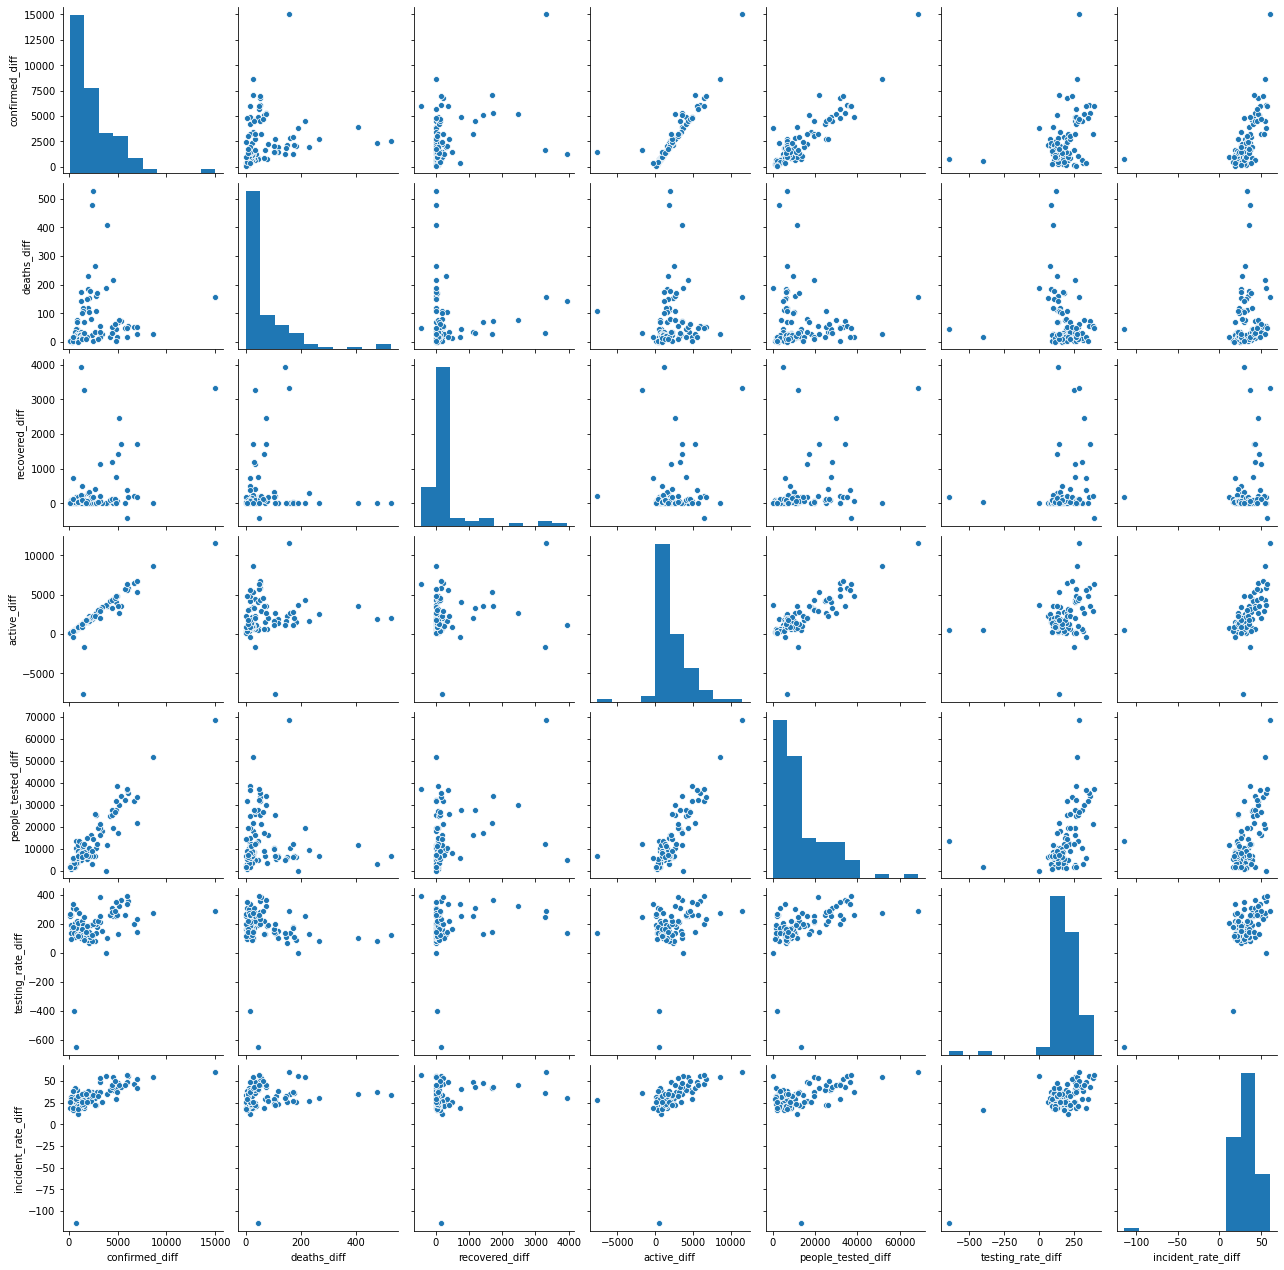

In [407]:
bad_mean_filled = bad_mean.fillna(0)
print(bad_mean.corr())
sns.pairplot(bad_mean)

In [ ]:
# Next, repeat the entire model initialization process for the "risky" (or "bad") data
x_allfeats = ['confirmed_diff', 'deaths_diff', 'recovered_diff',
              'active_diff', 'testing_rate_diff', 'people_tested_diff']
X_bad = bad_2Dresampled[x_allfeats]
y_bad = bad_2Dresampled.incident_rate_diff

#fit
bad_mlinreg = LinearRegression()
bad_mlinreg.fit(X_bad, y_bad)

# get intercept and coef
bad_coef = [round(c, 4) for c in bad_mlinreg.coef_]
bad_int =  bad_mlinreg.intercept_

# print values 
print("intercept: ", round(bad_int, 4))
print("coef: {}\n".format(bad_coef))

[print(tups,'\f') for tups in list(zip(X_bad, bad_coef))]


bad_ypred = bad_mlinreg.predict(X_bad)
bad_r2 = metrics.r2_score(y_bad, bad_ypred)

print('\nR^2 score for "bad" data model: ', round(bad_r2, 4))

# Stopped here 07-20-2020:
* fix the bug above where bad_2Dresampled only has incident_rate_diff column: aggregate for all other feature columns for the mlr to work.
* evaluate the predictive model for bad_mean data
* try log linear reg after classifying and merging two data for test/train 

# Log linear regression 
<p> 1. add 'risk_type' column with all values 0 in the good_mean data and 1 in bad_mean

In [142]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics.cluster import silhouette_score



array([7.9868601 , 7.31467331, 7.66256707, 7.10993758, 8.26097945,
       8.85498628, 7.24674205, 7.93098041, 7.54382805, 5.3714819 ])